Let's now talk about classification and as an introduction we will focus on binary classifcation where $y$ can take on only two values, 0 and 1. For instance, if we are trying to build a spam classifier for email, then $x^{(i)}$ may be some features of an email and $y^{(i)}$ may be 1 if it is a spam mail, and 0 otherwise. 

In the context of classification, we often use the following notation
* $y^{(i)}$ is also called the **label** values
* 0 is also called the **negative** class
* 1 is also called the **positive** class

In this notebook, we will look at logistic regression for binary classification task. First we import needed modules

In [1]:
# import modules
import numpy as np
import time, sys

# add parent to search path
if '..' not in sys.path:
    sys.path.insert(0, '..')

    
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# imported helpers function   
from helpers import funcs, vis, glm

# matplotlib inline
%matplotlib inline

## Logistic regression
One could approach the classification above as a linear regression while ignoring the fact $y$ can only be either 0 or 1. However, this approach would perform poorly due to the following reasons
* the hypothesis function $h_\theta(x)$ is penalized if it is either much bigger than 1 or much smaller than 0
* $h_\theta(x)$ ignored the fact that $y$ can only be 0 or 1

To fix that, we will choose 

$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^Tx}}
$$

where 

$$
g(z) = \frac{1}{1+e^{-z}}
$$ 
is called the **logistic function** or the **sigmoid function**. Here is a plot showing $g(z)$

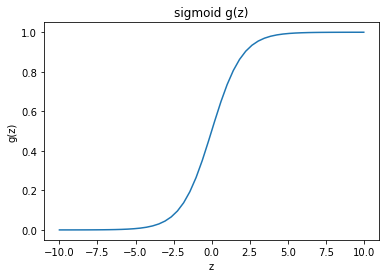

In [2]:
x = np.linspace(-10,10,50)
_ = vis.draw(x, funcs.sigmoid(x), 
             plot_type='plot', title='sigmoid g(z)',
             xy_labels = ['z', 'g(z)'])

The sigmoid function $g(z)$ has the following nice properties
* $g(z)\in [0, 1]$ for all $z\in\mathbb{R}$
* $g(z)$ is an increasing function and 
\begin{split}
\lim_{z\rightarrow -\infty} g(z) &= 0 \\
\lim_{z\rightarrow +\infty} g(z) &= 1
\end{split}
* $g(z)$ is continuous and its derivative is given by
$$
g'(z) = g(z)\left(1-g(z)\right)
$$

Now, we have chosen the hypothesis function, the next step is to define a loss function $J(\theta)$ given training samples $\left\{x^{(i)},\ y^{(i)}\right\}_{i=1}^m$.

Let us assume that 
\begin{split}
P\left(y=1|\ x;\theta\right) &= h_\theta(x)\\
P\left(y=0|\ x;\theta\right) &= 1 - h_\theta(x)
\end{split}

This can be written in a more compact form as

$$
P(y|x;\theta) = \left(h_\theta(x)\right)^y\left(1-h_\theta(x)\right)^{1-y}
$$

Assuming that all training samples are independent, then we write down the log-likelihood of the parameters as

\begin{split}
L(\theta) &= \prod_{i=1}^{m}P\left(y^{(i)}|x^{(i)};\theta\right)\\
          &= \prod_{i=1}^{m} \left(h_\theta(x^{(i)})\right)^{y^{(i)}} \left(1-h_\theta(x^{(i)})\right)^{1-y^{(i)}}
\end{split}

Then, we can use the method of maximize-log-likelihood
\begin{split}
\theta &= \mathrm{arg}\max_{\theta}\log \left(L(\theta)\right) \\
&= \mathrm{arg}\max_{\theta} \sum_{i=1}^{m}\left(y^{(i)}\log\left(h_\theta(x^{(i)} \right) + \left(1-y^{(i)}\right)\log\left(1-h_\theta(x^{(i)} \right)\right)
\end{split}

By taking negative log, we can define the loss function as

$$
J(\theta) = - \sum_{i=1}^{m}\left(y^{(i)}\log\left(h_\theta(x^{(i)} \right) + \left(1-y^{(i)}\right)\log\left(1-h_\theta(x^{(i)} \right)\right)
$$

To minimize $J(\theta)$ one can use **SGD**
$$
\theta:=\theta + \lambda \nabla_\theta J(\theta)
$$

To compute the gradient $\nabla_\theta J(\theta)$, we can just compute the derivative for the case of one training sample (then sum it up for general case)
\begin{split}
&\nabla_\theta\left( y\log\left(h_\theta(x)\right) + (1-y)\log\left(1-h_\theta(x)\right) \right)\\
=& \left(\frac{y}{h_\theta(x)} - \frac{1-y}{1 - h_\theta(x)}\right)\nabla_\theta h_\theta(x)\\
=& \frac{y - h_\theta(x)}{h_\theta(x)\left(1-h_\theta(x)\right)} h_\theta(x)\left(1-h_\theta(x)\right) x\\
=& \left(y - h_\theta(x)\right)x
\end{split}

This therefore gives us the update rule for a mini-batch $S$

$$
\theta_n = \theta_{n-1} - \lambda \sum_{i\in S} \left(h(x^{(i)}, \theta_{n-1})- y^{(i)}\right)x^{(i)}
$$

If we compare it with the update-rule for linear regression, we see it looks identical. It's supprising but actually logistic regression and linear regression are a sub-class of Generalized Linear Model.

Before looking at GLM, let's implement logistic regression.

We start by creating a synthetic dataset

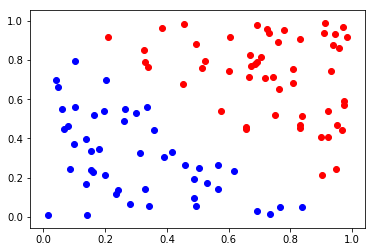

In [6]:
X, y = glm.demo_bin_class()

neg_idx = np.where(y==0)[0]
fig_ax = vis.draw(X[neg_idx, 0], X[neg_idx, 1], 
                  plot_type='scatter', colors='b')

pos_idx = np.where(y==1)[0]
_ = vis.draw(X[pos_idx, 0], X[pos_idx, 1], fig_ax=fig_ax,
                  plot_type='scatter', colors='r')

Let's devide the dataset into training set and validation set (we will use sklearn to do this)

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=42)

The logistic regression is implemented in `glm.py`, here we will use it to fit the above dataset

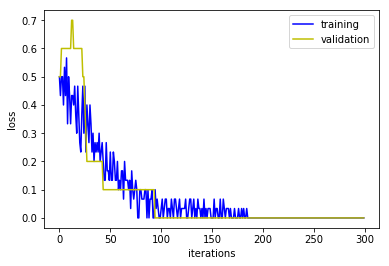

In [76]:
# create logistic regression model
clf = glm.LogitReg()

# define some hyperparameters
epochs = 100
batch_size =30
learning_rate = 5e-2

# fit model with the data
clf.fit(X_train, y_train, X_test, y_test, 
        batch_size, epochs, learning_rate =  learning_rate,
        debug = True)

# visualize training-loss vs validation-loss
_ = vis.draw(np.arange(len(clf._dbg_loss)), clf._dbg_loss, 
         xy_labels=['iterations', 'loss'], 
         legends=['training', 'validation'],
         colors = ['b','y'], plot_type = 'plot')